In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import statsmodels.api as sm
import networkx as nx
import graphviz
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

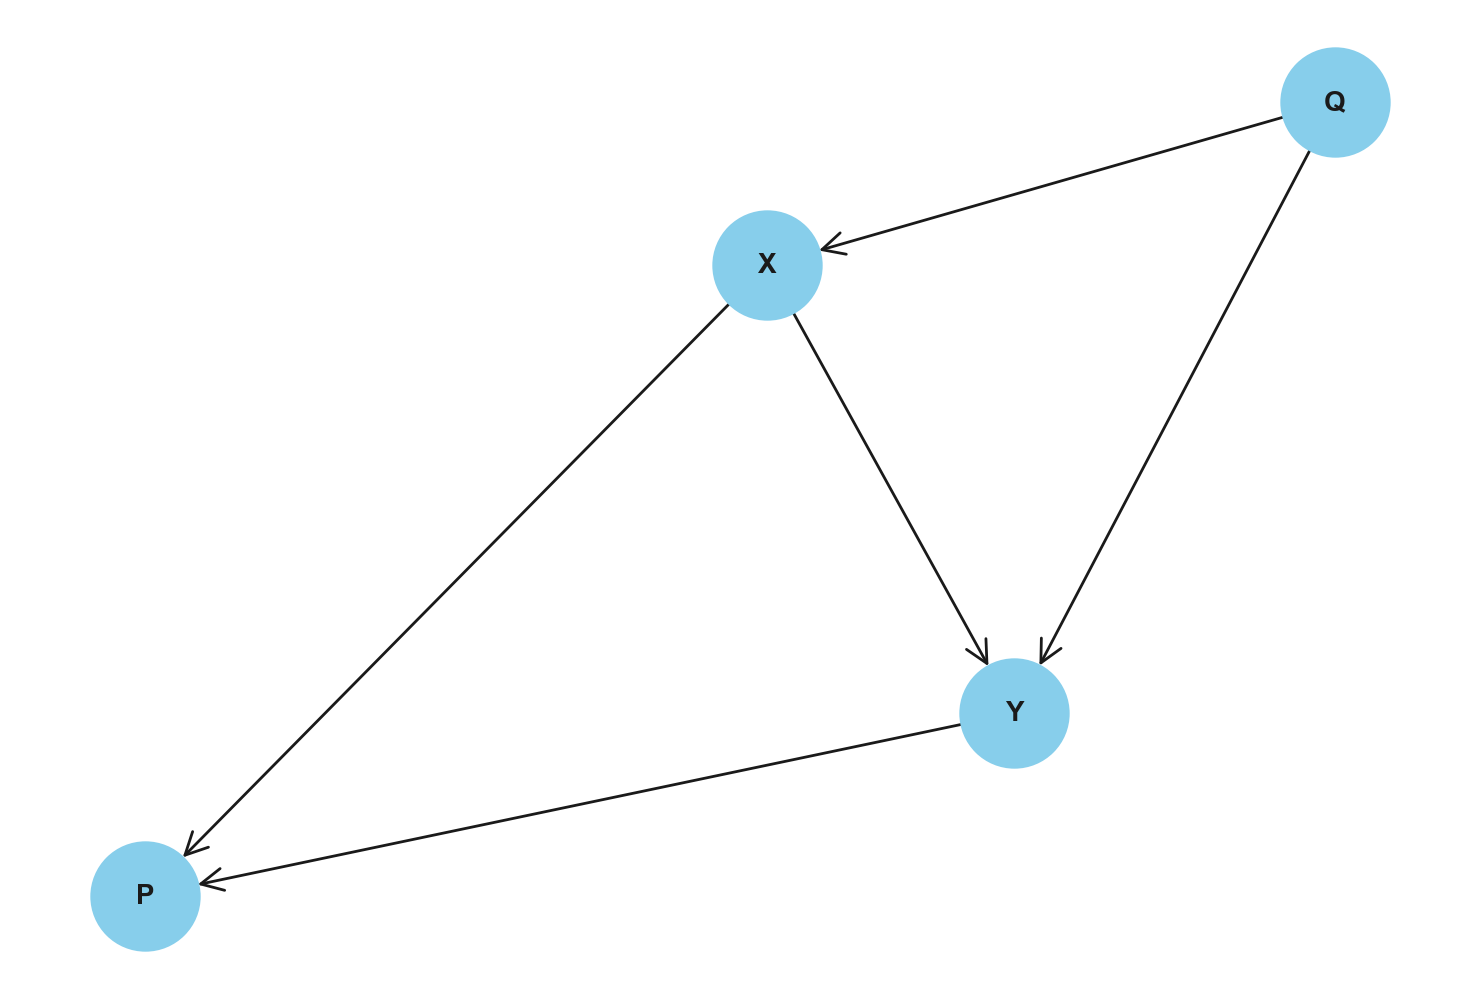

In [3]:
graph = nx.DiGraph()
#graph.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
graph.add_edges_from([("X", "Y"), ("X", "P"), ("Y", "P"), ("Q", "X"), ("Q", "Y")])

# Draw the graph
pos = nx.spring_layout(graph, seed=42)  # Position nodes using spring layout algorithm
nx.draw(graph, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20, arrowstyle="->")
plt.show()

In [4]:
N = 5_000
Q = rng.normal(size=N)
X = rng.normal(loc=0.14*Q, scale=0.4, size=N)
Y = rng.normal(loc=0.7*X + 0.11*Q, scale=0.24, size=N)
P = rng.normal(loc=0.43*X + 0.21*Y, scale=0.22, size=N)
df = pd.DataFrame({"Q": Q, "X": X, "Y": Y, "P": P})

df.head()

,Q,X,Y,P
0,-1.423825,-0.421305,-0.498653,0.039523
1,1.263728,0.518683,0.576752,0.059713
2,-0.870662,0.354544,0.157422,0.367875
3,-0.259173,0.135539,0.307791,0.016444
4,-0.075343,-0.048982,0.114759,0.134512


In [5]:
model = bmb.Model("Y ~ X", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

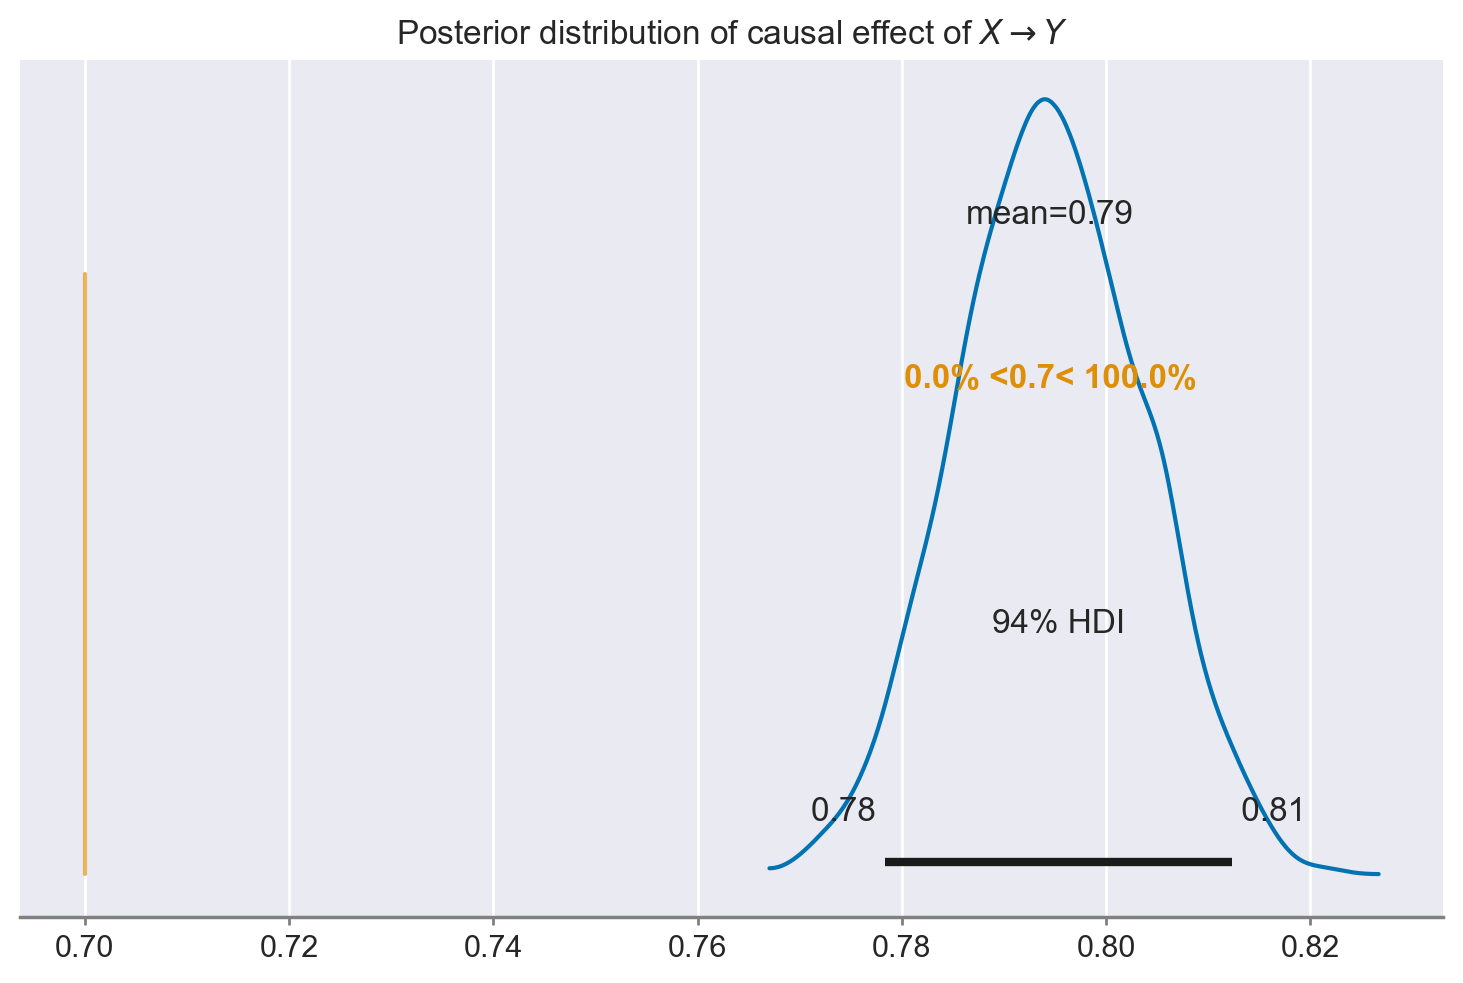

In [6]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [7]:
model = bmb.Model("Y ~ Q + X + P", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

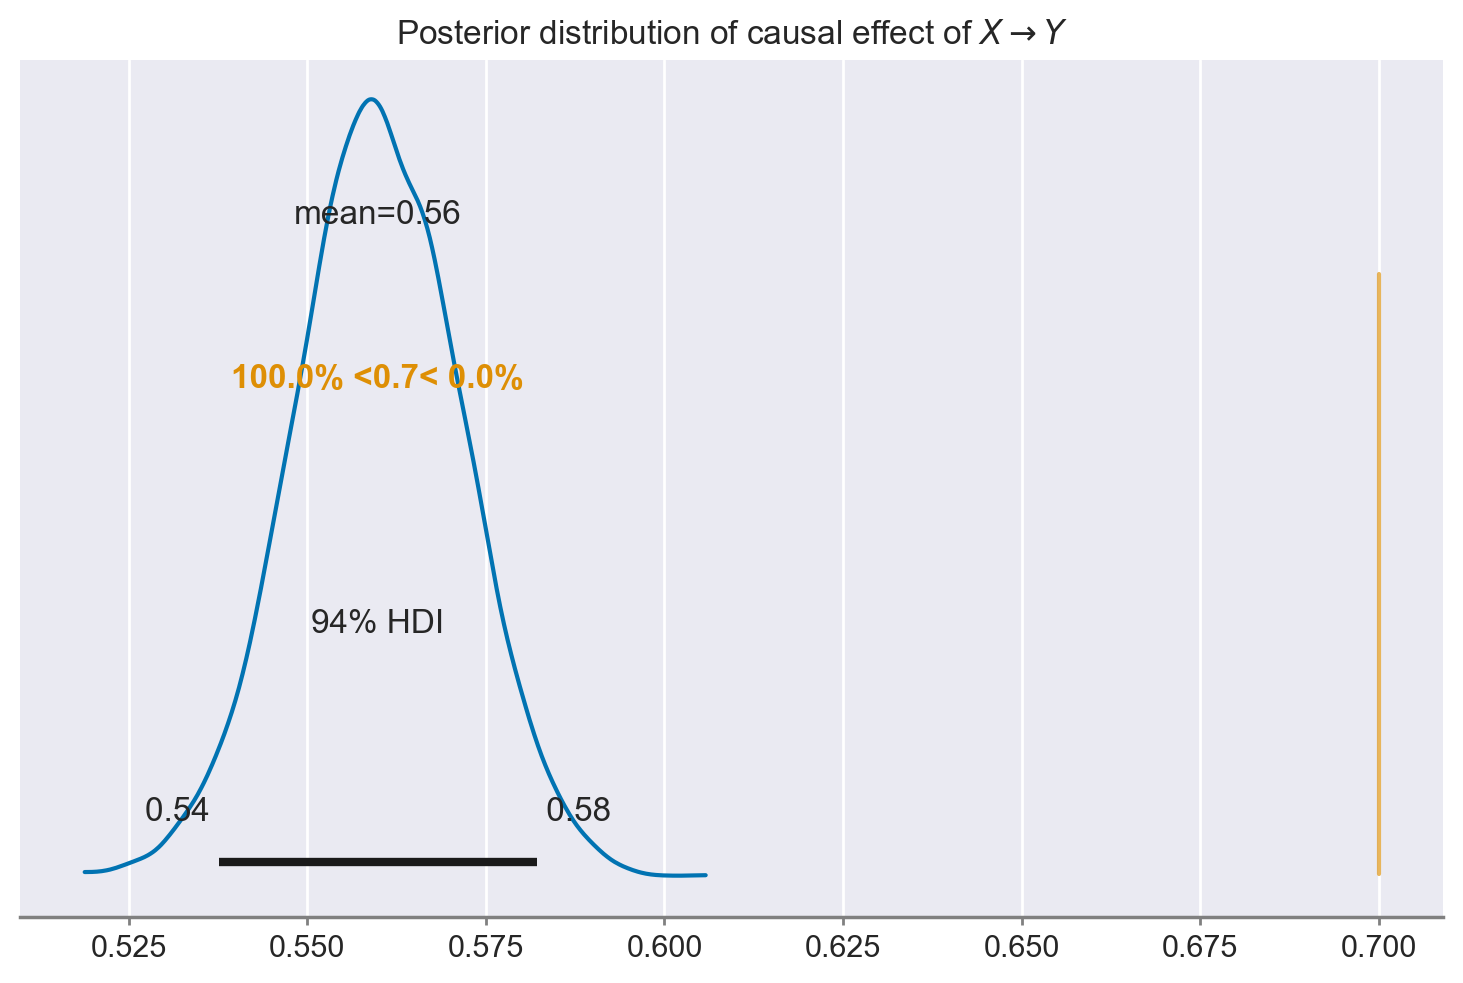

In [8]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [9]:
model = bmb.Model("Y ~ X + Q", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

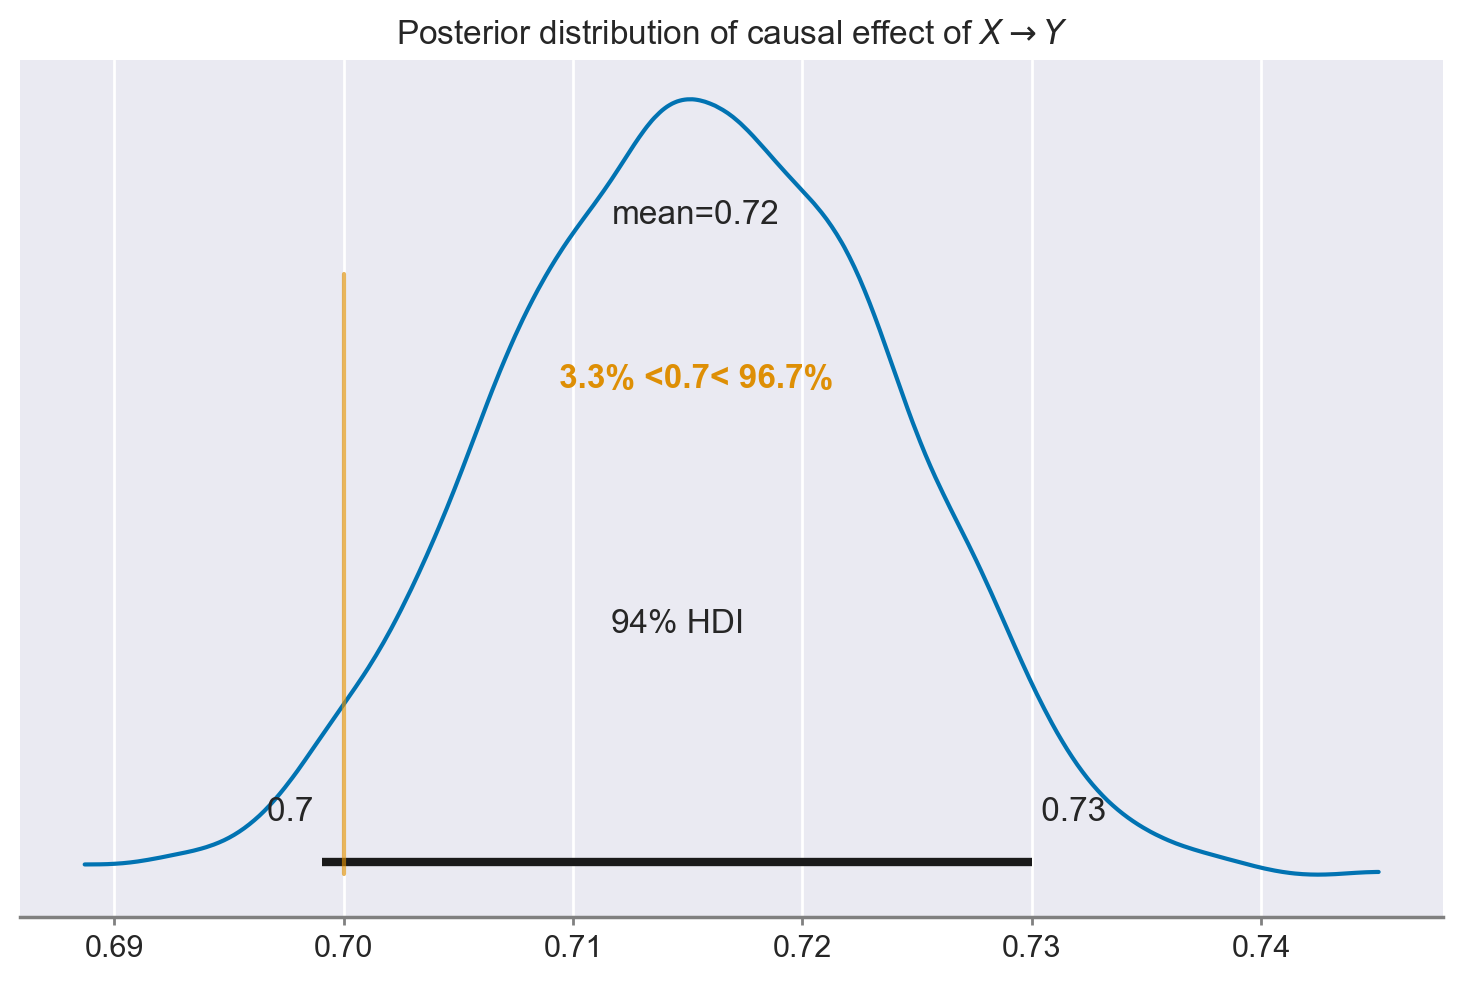

In [10]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

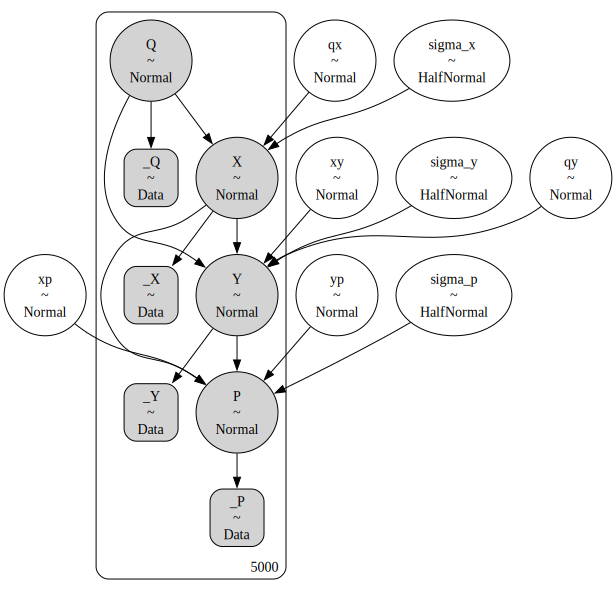

In [11]:
with pm.Model() as model:
    # data
    _Q = pm.MutableData("_Q", df["Q"])
    _X = pm.MutableData("_X", df["X"])
    _Y = pm.MutableData("_Y", df["Y"])
    _P = pm.MutableData("_P", df["P"])

    # priors on slopes
    # x ~ q
    qx = pm.Normal("qx")
    # y ~ x + q
    xy = pm.Normal("xy")
    qy = pm.Normal("qy")
    # p ~ x + y
    xp = pm.Normal("xp")
    yp = pm.Normal("yp")

    # priors on sd's
    sigma_x = pm.HalfNormal("sigma_x")
    sigma_y = pm.HalfNormal("sigma_y")
    sigma_p = pm.HalfNormal("sigma_p")
    
    # model
    Q = pm.Normal("Q", observed=_Q)
    X = pm.Normal("X", mu=qx*Q, sigma=sigma_x, observed=_X)
    Y = pm.Normal("Y", mu=xy*X + qy*Q, sigma=sigma_y, observed=_Y)
    P = pm.Normal("P", mu=xp*X + yp*Y, sigma=sigma_p, observed=_P)

pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

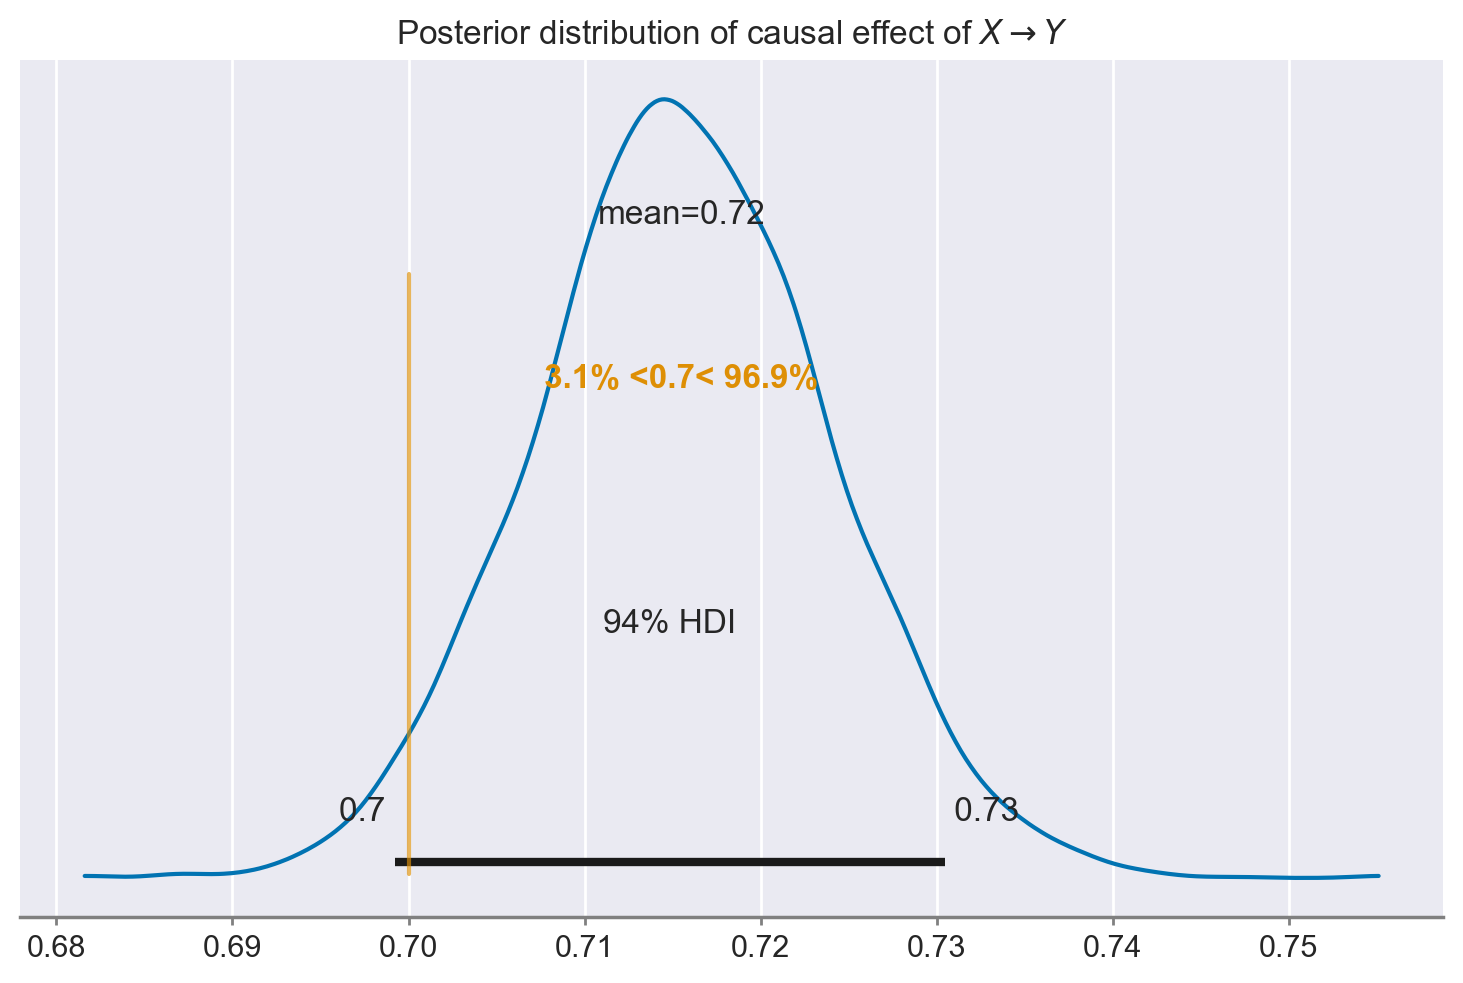

In [13]:
ax = az.plot_posterior(idata, var_names="xy", ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

bambi      : 0.13.0
scipy      : 1.13.1
graphviz   : 0.20.3
pymc       : 5.15.1
matplotlib : 3.8.4
networkx   : 3.3
numpy      : 1.26.4
seaborn    : 0.13.2
statsmodels: 0.14.2
pandas     : 2.2.2
arviz      : 0.18.0

Watermark: 2.4.3

